# <center>Image captioning model training

In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '20'
# Project imports
from src.net.model import Model
from src.data_processing.dataset import Collate, Database, LmdbDataset
from src.data_processing.vocabulary import Vocabulary
from src.utils.predictor import Predictor
from src.utils.history import History
# Third party imports
import torch
import lightning as L
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')

# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 6
BATCH_SIZE = 64
# DATABASE_TRAIN_PATH = '/mnt/s/CV/data_lmdb_release/training/MJ/MJ_train'
DATABASE_TRAIN_PATH = '/mnt/s/CV/data_lmdb_release/training/ST'
DATABASE_VALID_PATH = '/mnt/s/CV/data_lmdb_release/validation'

# Model hyperparametres
D_MODEL = 256
NUM_HEADS = 4
INPUT_CHANNELS = 1
LR_MAX = 1e-4
LR_MIN = 1e-5
T_MAX = 2

## Initialize vocabulary, datasets and dataloaders

In [2]:
vocab = Vocabulary()

train_db = Database(DATABASE_TRAIN_PATH, max_readers=NUM_WORKERS)
valid_db = Database(DATABASE_VALID_PATH, max_readers=NUM_WORKERS)

dataset_train = LmdbDataset(train_db, vocab, sample='train')
dataset_valid = LmdbDataset(valid_db, vocab, sample='valid')
dataset_test = LmdbDataset(valid_db, vocab, sample='test')

collate = Collate(pad_idx=vocab.char2idx['<PAD>'])
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=False, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=False, num_workers=NUM_WORKERS)

print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {len(dataset_train)}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 72
Train size: 5522808
Val/test size: 3496/3496


## Configure model and callbacks

In [3]:
# Model
config = dict(
    vocab=vocab,
    d_model=D_MODEL,
    input_channels=INPUT_CHANNELS,
    lr_max=LR_MAX,
    lr_min=LR_MIN,
    t_max=T_MAX,
    num_heads=NUM_HEADS
)
model = Model(**config).cuda()
# Callbacks and logger
logger = CSVLogger('logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='weights',
    filename='checkpoint',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)
# early_stop_callback = EarlyStopping(
#     monitor='val_CE',
#     min_delta=0.01,
#     patience=2,
#     mode='min'
# )

## Training

In [4]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
        # early_stop_callback
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train) # Every epoch
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                    | Params | Mode 
----------------------------------------------------------------
0 | encoder     | ViTSTR                  | 9.6 M  | train
1 | embedding   | Embedding               | 18.4 K | train
2 | transformer | TransformerDecoderLayer | 1.6 M  | train
3 | ffn         | Sequential              | 65.8 K | train
4 | linear      | Linear                  | 18.5 K | train
----------------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.176    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.


## Evaluation on test set

In [5]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='weights/checkpoint.ckpt');

Restoring states from the checkpoint path at weights/checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │    0.4801349341869354     │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [6]:
model = model.__class__.load_from_checkpoint('weights/checkpoint.ckpt', vocab=vocab)

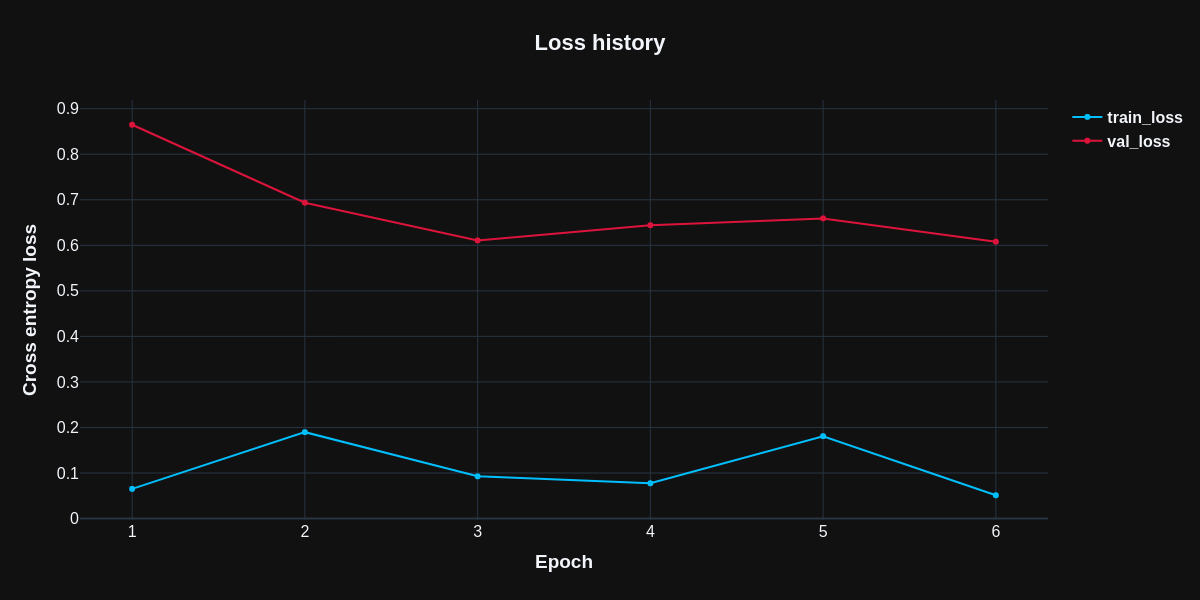

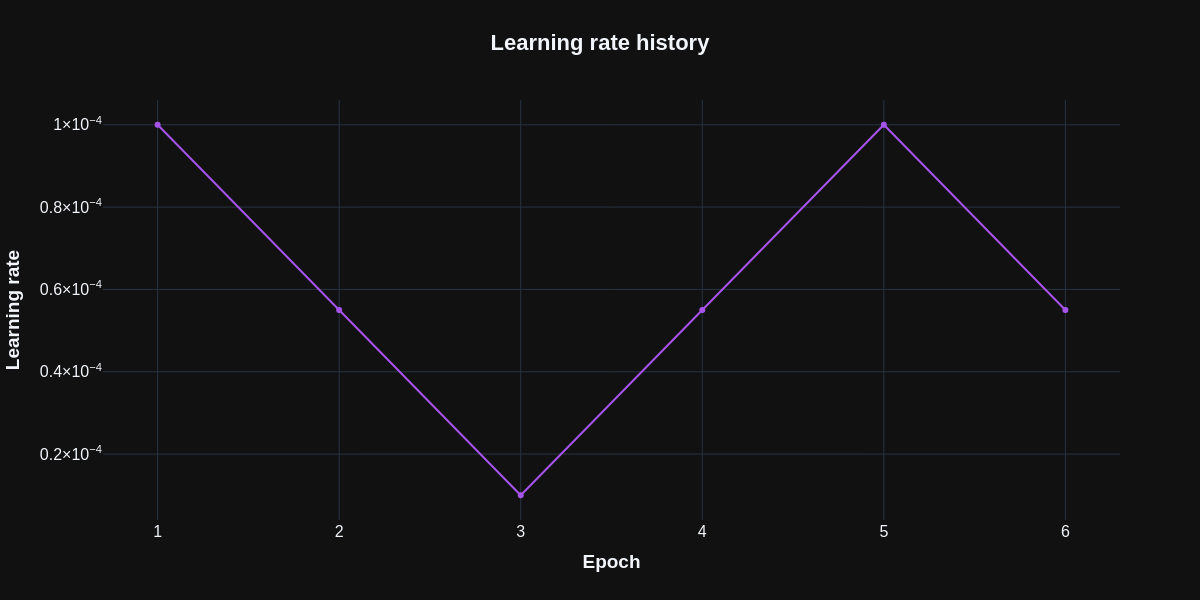

In [8]:
history_visualizer = History('logs/lightning_logs/version_0/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

Predicted caption: exit
Target caption: exit


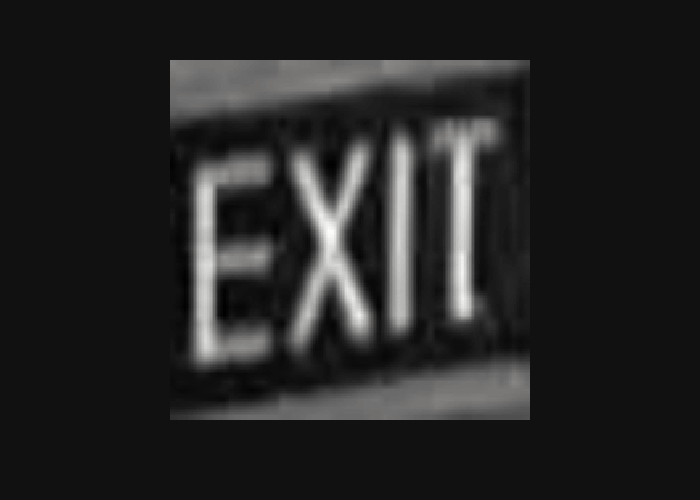

Predicted caption: the
Target caption: quick


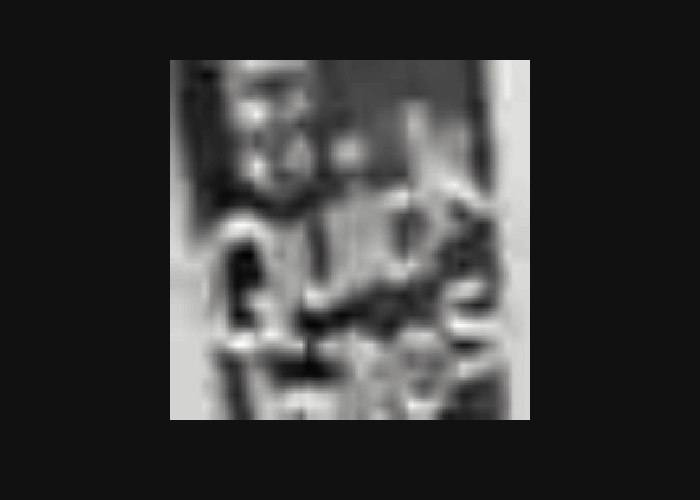

Predicted caption: guess
Target caption: guess


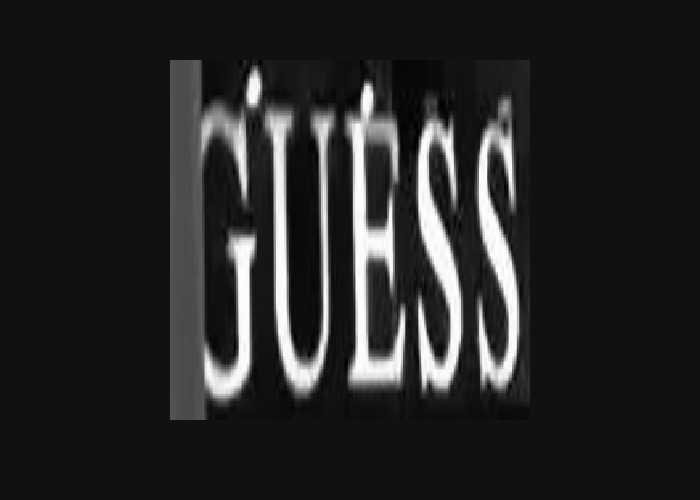

Predicted caption: zara
Target caption: zara


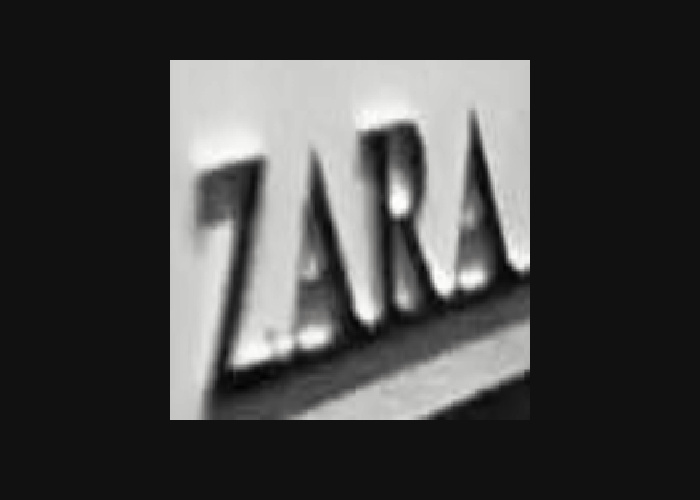

Predicted caption: some
Target caption: sale


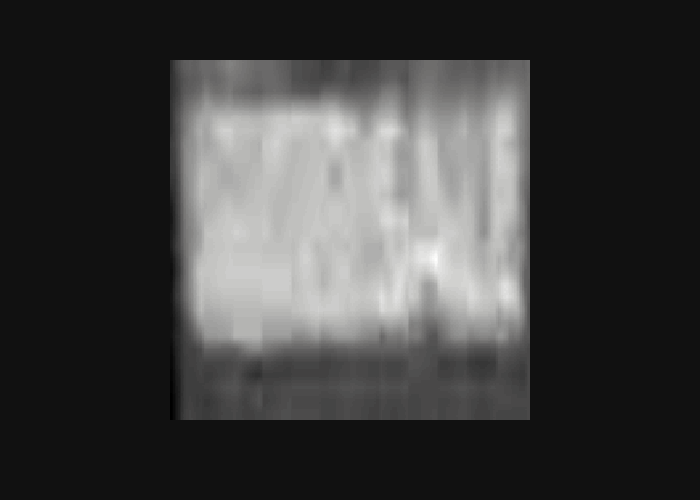

Predicted caption: calvin
Target caption: calvin


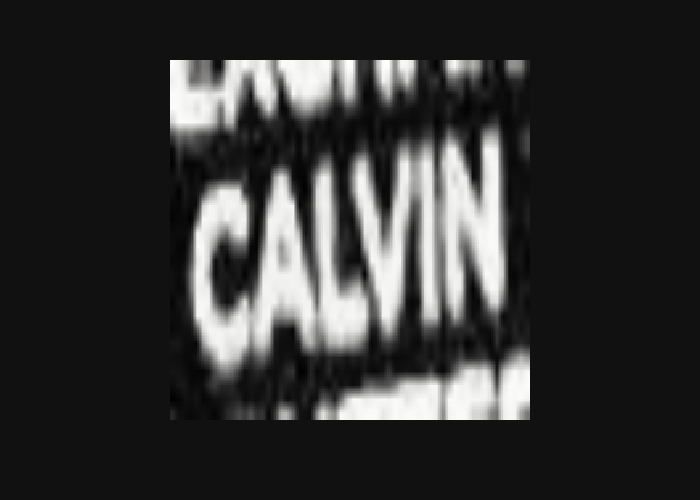

Predicted caption: sal
Target caption: sal


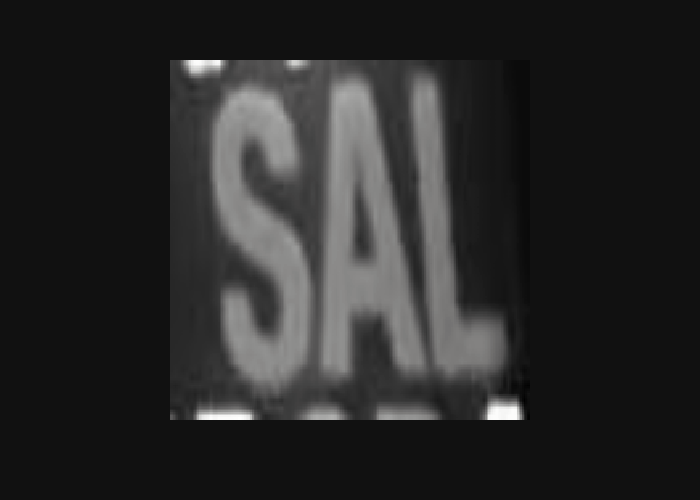

Predicted caption: part
Target caption: barret


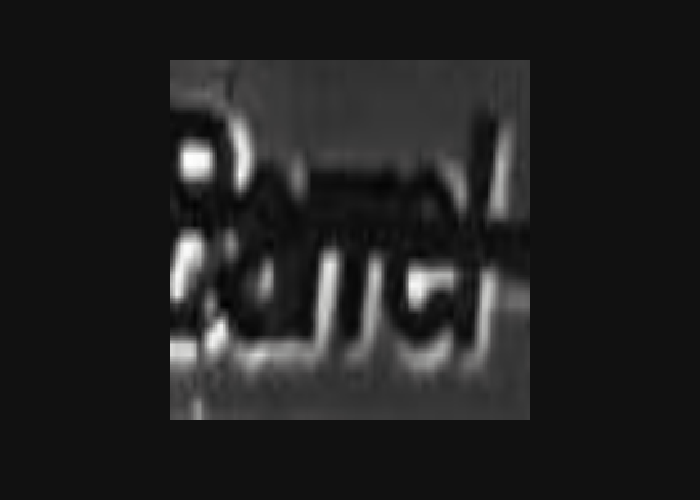

Predicted caption: link
Target caption: link


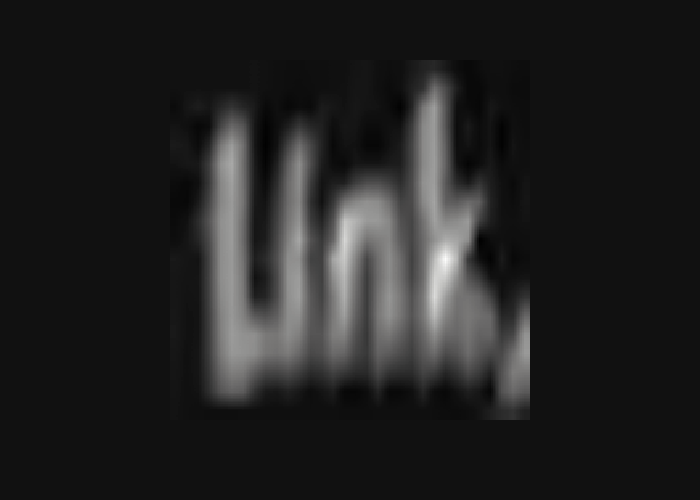

Predicted caption: interet
Target caption: thefacesho


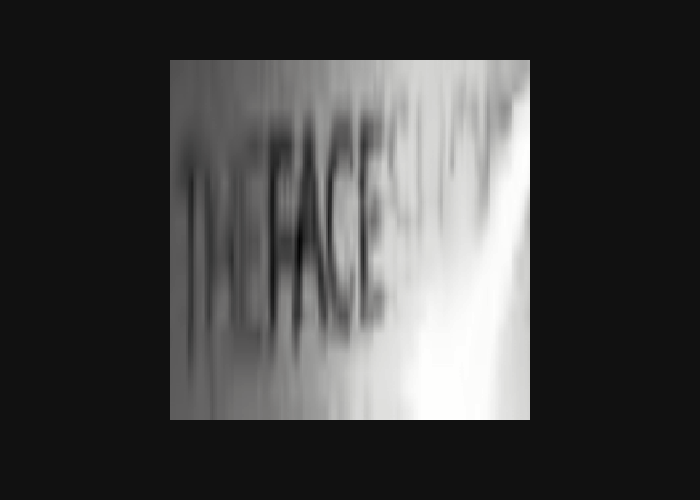

In [9]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_test, model=model, n_samples=10)